# <span style="color:#0b486b">  FIT5215: Deep Learning (2022)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/> <br/>
*Tutor:*  **Mr Tuan Nguyen**  \[tuan.ng@monash.edu \] |**Mr Anh Bui** \[tuananh.bui@monash.edu\] | **Mr Xiaohao Yang** \[xiaohao.yang@monash.edu \] | **Mr Md Mohaimenuzzaman** \[md.mohaimen@monash.edu \] |**Mr Thanh Nguyen** \[Thanh.Nguyen4@monash.edu \] |
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
******

# <span style="color:#0b486b">Tutorial 09a: Words to Vectors (Word2Vec)</span> <span style="color:red">*****</span> #

This tutorial shows you how to exploring the embedding space with gensim, which is a package that contains several SOTA word2vec models trained on large text corpora. More specifically, this tute 09 consists of two parts:
- In the first part, you study how to use gensim to work out word embeddings for words in a vocabulary, find the most similar words to a given word, answer a query, and find words that are out-of-the-rule.
- In the second part, you speculate how to employ vector representations of words as feature vectors for ML algorithms.

*Acknowledgement: Part III of this tutorial was developed based on TensorBoard Guide to [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin)*

We first import some necessary packages and libraries.

In [1]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## <span style="color:#0b486b">I. Introduction of the gensim package</span> ##

We use gensim package developed at [here](https://radimrehurek.com/gensim/index.html), which contains several SOTA pretrained word2vec models trained on large datasets. To use this package, you need to install it as:
- ><span style="color:red">pip install --upgrade gensim</span>

In addition, gensim contains the following pretrained word2vect models:
- **Word2Vec**: Two flavours, one trained on Google news (3 million word vectors based on 3 billion tokens), and one trained on Russian corpora (word2vec-ruscorpora-300, word2vec-google-news-300).
- **GloVe**: Two flavours, one trained on the Gigawords corpus (400,000-word vectors based on 6 billion tokens), available as 50d, 100d, 200d, and 300d vectors, and one trained on Twitter (1.2 million word vectors based on 27 billion tokens), available as 25d, 50d, 100d, and 200d vectors (glove-wikigigaword-50, glove-wiki-gigaword-100, glove-wiki-gigaword-200, glovewiki-gigaword-300, glove-twitter-25, glove-twitter-50, glove-twitter-100, glove-twitter-200).
- **fastText**: 1 million word vectors trained with subword information on Wikipedia 2017, the UMBC web corpus, and statmt.org news dataset (16B tokens) (fastText-wiki-news-subwords-300).
- **ConceptNet Numberbatch**: An ensemble embedding that uses the ConceptNet semantic network, the paraphrase database (PPDB), Word2Vec, and GloVe as input. 

## <span style="color:#0b486b">II. How to use gensim package</span> ##

In [2]:
import gensim.downloader as api
from gensim.models import Word2Vec
import json

We download the dataset *text8* and train a Word2Vect model on this dataset. We then save the model to the hard disk at the file *text8-word2vec.bin*. This operation might take a while.

Here is the signature of the class *Word2Vec*: 
- <span style="color:red"> Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3,  min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=\<built-in function hash\>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None) </span>


In [3]:
dataset = api.load("text8") # load text8 dataset

[==================================================] 100.0% 31.6/31.6MB downloaded


In [4]:
info = api.info("text8")
print(json.dumps(info, indent='\t'))

{
	"num_records": 1701,
	"record_format": "list of str (tokens)",
	"file_size": 33182058,
	"reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py",
	"license": "not found",
	"description": "First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.",
	"checksum": "68799af40b6bda07dfa47a32612e5364",
	"file_name": "text8.gz",
	"read_more": [
		"http://mattmahoney.net/dc/textdata.html"
	],
	"parts": 1
}


In [5]:
model = Word2Vec(dataset)  # train Word2Vec model
model.save("./text8-word2vec.bin") # save the embedding matrix

We load the model from hard disk and show the vocabulary. Note that we use `KeyedVectors` to load model. The main difference between `KeyedVectors` and `Word2Vec` model is that `KeyedVectors` do not support further training. On the other hand, by shedding the internal data structures necessary for training, `KeyedVectors` offer a smaller RAM footprint and a simpler interface.

In [6]:
from gensim.models import KeyedVectors
model = KeyedVectors.load("./text8-word2vec.bin")
word_vectors = model.wv
print(len(word_vectors.key_to_index))

71290


In [7]:
words = word_vectors.key_to_index.keys()
print([x for i, x in enumerate(words) if i < 10])
print("king" in words)

['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two']
True


The function (method) *get_vector* returns the vector representation for a given word.

In [8]:
word_vectors.get_vector('king')
print(word_vectors.get_vector('king').shape)

(100,)


t-SNE is an excellent tool to project data from high-dimensional space to 2D or 3D space for visualization while preserving the geometry of data (i.e., if two points are close in the original space, they are still close in the projected space). In what follows, we use t-SNE to project our data in a 100-dimensional space to a 2D space and then visual words and their 2D coordinates.

In [9]:
def plot2D_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(20, 20))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

C:\Users\trung\Anaconda3\envs\tf2xx_cpu\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\trung\Anaconda3\envs\tf2xx_cpu\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


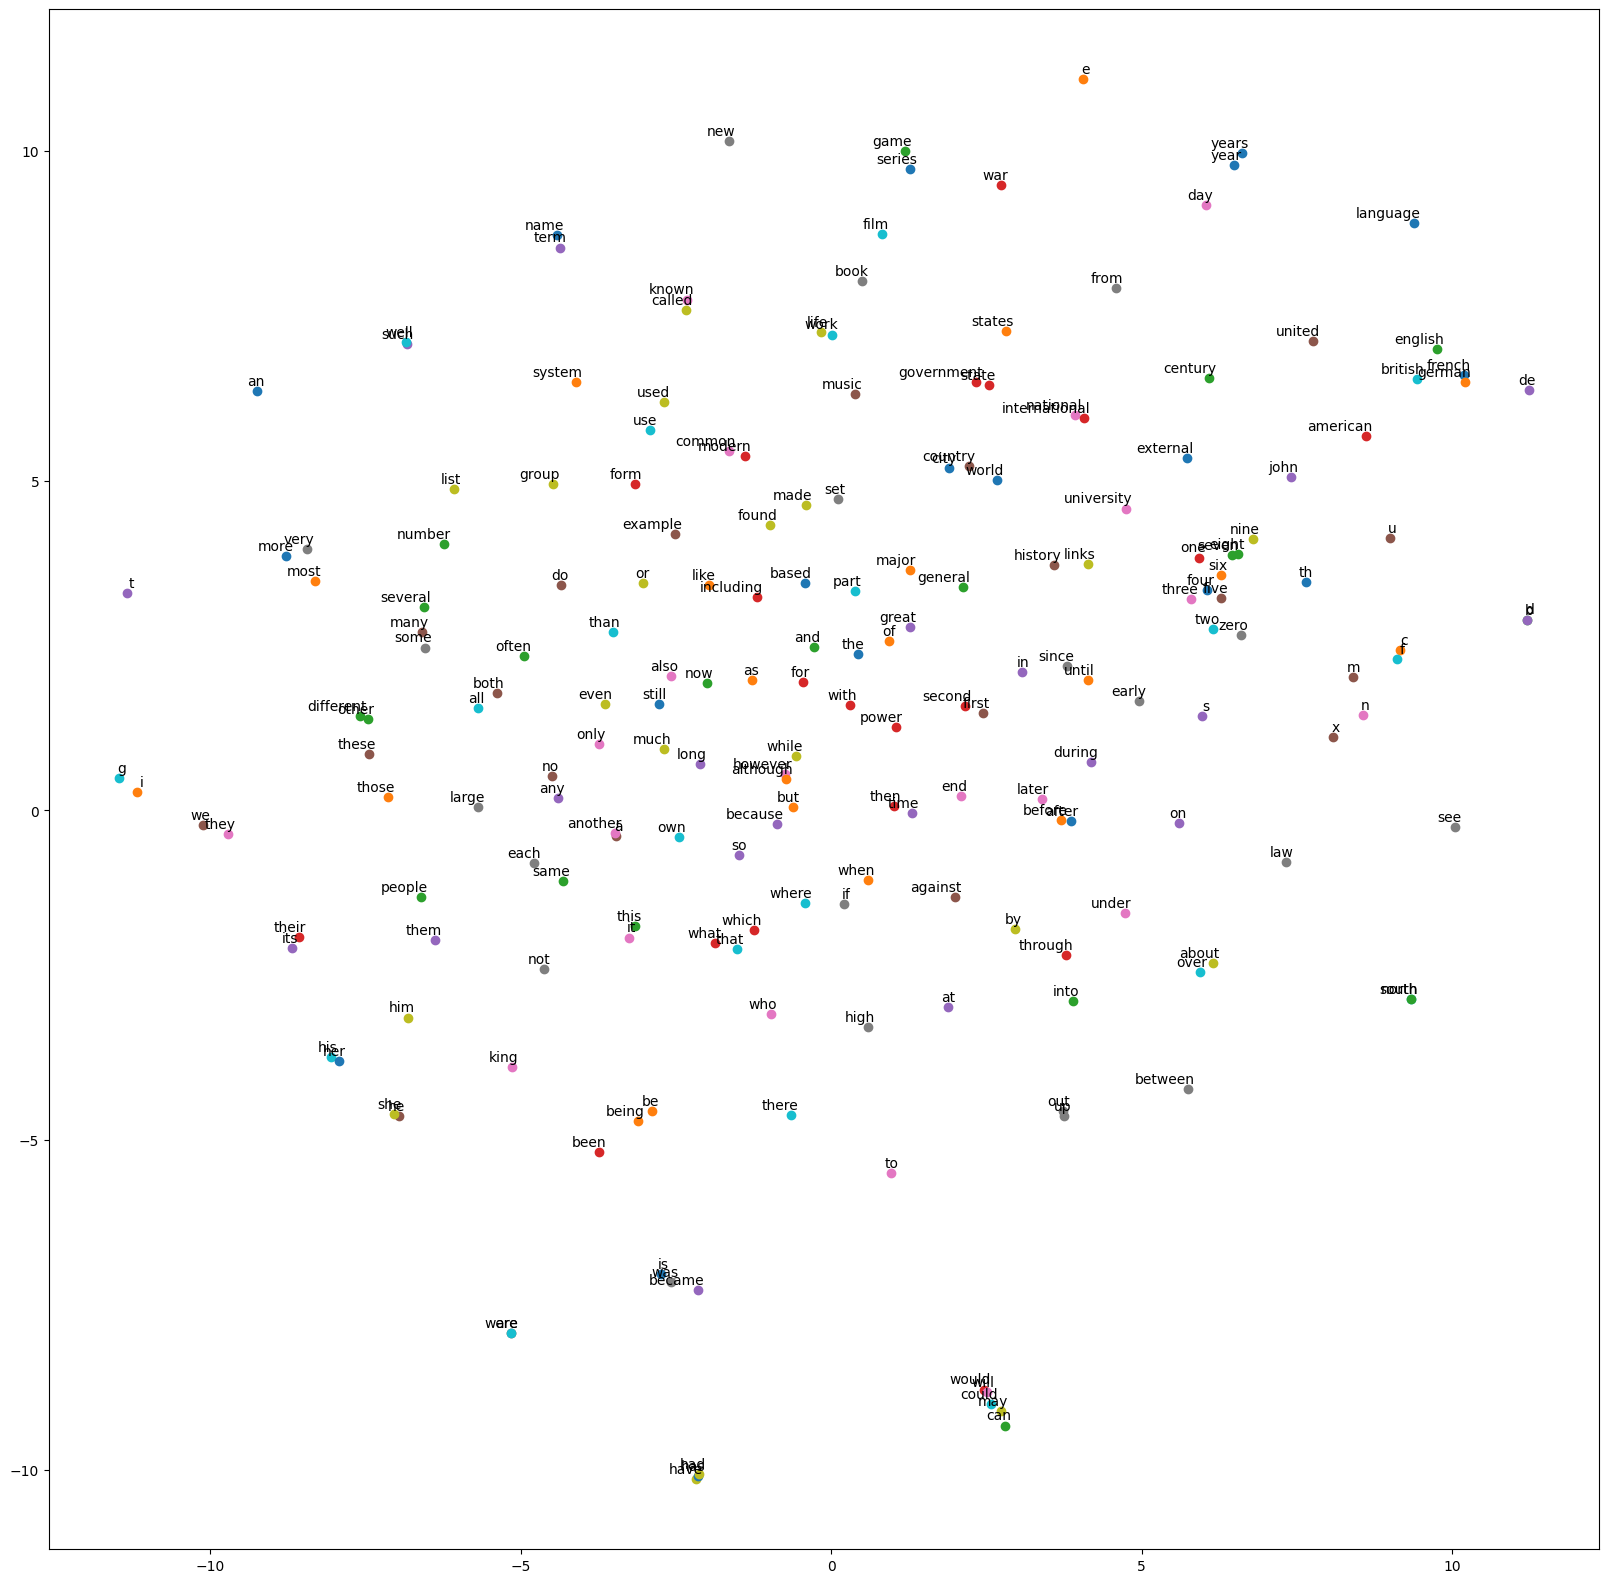

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 200
words = list(word_vectors.key_to_index.keys())[0:plot_only]
embeddings = np.array([word_vectors.get_vector(word) for word in words])
low_dim_embs = tsne.fit_transform(embeddings)
plot2D_with_labels(low_dim_embs, words)

We now plot word embeddings in a 3D space.

In [14]:
from mpl_toolkits.mplot3d import Axes3D
def plot3D_with_labels(low_dim_embs, labels):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(labels):
        x,y,z =  low_dim_embs[i,:]
        ax.scatter(x, y, z)
        ax.text(x, y, z, label)
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()

In [15]:
plot_only = 200
words = list(word_vectors.key_to_index.keys())[0:plot_only]
print(words)

['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by', 'that', 'four', 'six', 'seven', 'with', 'on', 'are', 'it', 'from', 'or', 'his', 'an', 'be', 'this', 'which', 'at', 'he', 'also', 'not', 'have', 'were', 'has', 'but', 'other', 'their', 'its', 'first', 'they', 'some', 'had', 'all', 'more', 'most', 'can', 'been', 'such', 'many', 'who', 'new', 'used', 'there', 'after', 'when', 'into', 'american', 'time', 'these', 'only', 'see', 'may', 'than', 'world', 'i', 'b', 'would', 'd', 'no', 'however', 'between', 'about', 'over', 'years', 'states', 'people', 'war', 'during', 'united', 'known', 'if', 'called', 'use', 'th', 'system', 'often', 'state', 'so', 'history', 'will', 'up', 'while', 'where', 'city', 'being', 'english', 'then', 'any', 'both', 'under', 'out', 'made', 'well', 'her', 'e', 'number', 'government', 'them', 'm', 'later', 'since', 'him', 'part', 'name', 'c', 'century', 'through', 'because', 'x', 'university'

C:\Users\trung\Anaconda3\envs\tf2xx_cpu\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\trung\Anaconda3\envs\tf2xx_cpu\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


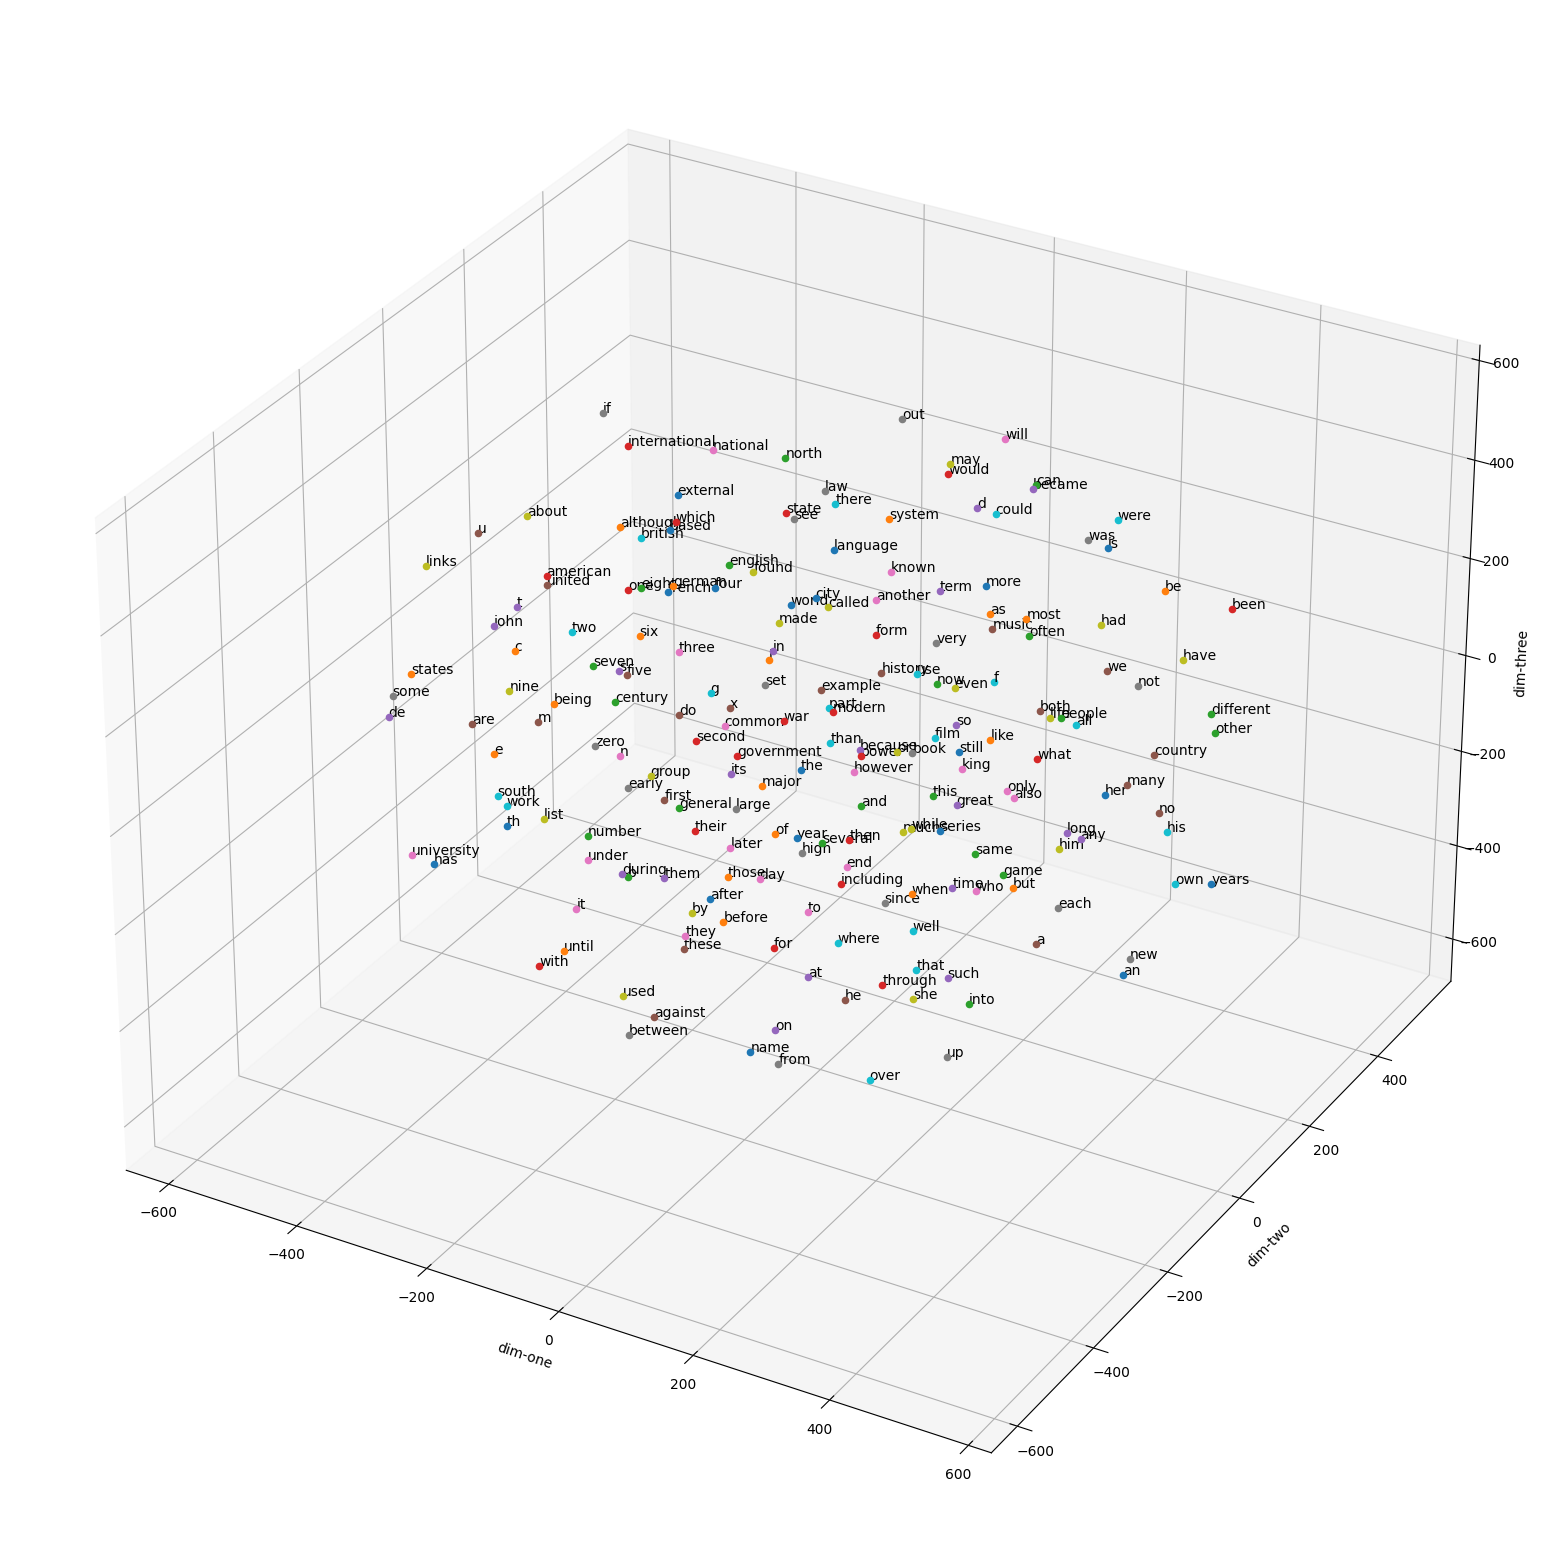

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
plot_only = 200
words = list(word_vectors.key_to_index.keys())[0:plot_only]
embeddings= np.array([word_vectors.get_vector(word) for word in words])
low_dim_embs = tsne.fit_transform(embeddings)
plot3D_with_labels(low_dim_embs, words)

Return the cosine similarities of a word and other words.

In [18]:
word_vectors.cosine_similarities(word_vectors.get_vector('king'), [word_vectors.get_vector('queen'), word_vectors.get_vector('australia')])

array([0.7223219 , 0.09035411], dtype=float32)

Find the 10 most similar words of a given word.

In [19]:
word_vectors.similar_by_word('king',10)

[('prince', 0.7500482201576233),
 ('queen', 0.7223218679428101),
 ('throne', 0.7108598351478577),
 ('emperor', 0.7034519910812378),
 ('kings', 0.681533694267273),
 ('pharaoh', 0.677660346031189),
 ('elector', 0.6640313863754272),
 ('regent', 0.6626291871070862),
 ('vii', 0.6579687595367432),
 ('constantine', 0.6571701765060425)]

This function helps to print out the results returned by *similar_by_word('king',10)* in a better form.

In [20]:
def print_most_similar(word_conf_pairs, k):
    for i, (word, conf) in enumerate(word_conf_pairs):
        print("{:.3f} {:s}".format(conf, word))
        if i >= k-1:
            break
    if k < len(word_conf_pairs):
        print("...")

In [21]:
print_most_similar(word_vectors.most_similar("king"), 10)

0.750 prince
0.722 queen
0.711 throne
0.703 emperor
0.682 kings
0.678 pharaoh
0.664 elector
0.663 regent
0.658 vii
0.657 constantine


In [22]:
print_most_similar(word_vectors.most_similar("china"), 10)

0.816 japan
0.754 taiwan
0.686 india
0.658 afghanistan
0.650 korea
0.648 cambodia
0.642 indonesia
0.640 turkey
0.638 pakistan
0.627 thailand


This will compute `france + berlin - paris` and find the most similar word which is `german` (so surprise).

In [23]:
print_most_similar(word_vectors.most_similar(positive=["france", "berlin"], negative=["paris"]), 1)

0.771 germany
...


This returns the word that does not match the rest.

In [24]:
print(word_vectors.doesnt_match(["hindus", "parsis", "singapore","christians"]))

singapore


The function *similarity* returns the similarity of two given words.

In [25]:
for word in ["woman", "dog", "whale", "tree"]:
    print("similarity({:s}, {:s}) = {:.3f}".format("man", word, word_vectors.similarity("man", word)))

similarity(man, woman) = 0.743
similarity(man, dog) = 0.433
similarity(man, whale) = 0.286
similarity(man, tree) = 0.258


In [26]:
print(print_most_similar(word_vectors.similar_by_word("singapore"), 5))

0.866 malaysia
0.846 indonesia
0.810 thailand
0.807 zambia
0.802 uganda
...
None


**<span style="color:red">Exercise 1</span>:** Given two vectors $u, v$, the cosine similarity between $u,v$ is defined as

$cos\_sim(u,v)=\frac{<u,v>}{||u||_{2}||v||_{2}}=\frac{\sum_{i=1}^{d}u_{i}v_{i}}{\left(\sum_{i=1}^{d}u_{i}^{2}\right)^{1/2}\left(\sum_{i=1}^{d}v_{i}^{2}\right)^{1/2}}$

Write code for a function `cos_sim(word1, word2, model)` with three parameters the first word `word1`, the second word `word2`, and a pretrained Word2Vec model. This function returns the cosine similarity of vector representations of word1 and word2 using the given pretrained Word2Vec model `model`. Test your function by finding the cosine similarity of your words of interest.

Moreover, the above cosine similarity returns a value between $[-1, 1]$. Assume that you prefer a similarity between $[0,1]$, suggest a reasonable transformation for this purpose and modify your code accordingly.

## <span style="color:#0b486b">III. Data Visualization using the Embedding Projector in TensorBoard</span> ##

TensorBoard provides a great tool [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) that performs dimension reduction using three popular methods, namely UMAP, PCA, and t-SNE. The tool is useful to visualize high-dimensional data, observe and understand semantic relationships of the data in embedding space.

In [27]:
from tensorboard.plugins import projector

We first create a new folder for storing the embedding, metadata for importing labels, and a configuration file for the projector.

In [28]:
log_dir='embeddings/example'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

Let us make an embedding matrix of 200 sample words.

In [29]:
embedding_sample = [word_vectors.get_vector(word) for word in words]
embedding_sample = np.asarray(embedding_sample)
print(embedding_sample.shape)

(200, 100)


Meta data is neccesary to label the data points.

In [30]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for word in words:
        f.write("{}\n".format(word))

Now we need to save the embedding matrix as a TensorFlow variable, store the embedding and configure the projector. After running the code below, files are created in the folder `log_dir`.

In [31]:
weights = tf.Variable(embedding_sample)

checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()

embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

Finally, all we need to do is to run the tensorboard, choose the tab `Projector` and interpret word embeddings in the embedding space after running dimensionality reduction algorithms.

- ><span>tensorboard --logdir embeddings/example</span>

## <span style="color:#0b486b">IV. Use Word2Vec in conjunction with classifiers</span> ##

In practice, we might encounter a dataset of symbolic representations for example sentences as sequences of words, programs as sequences of statements, graphs including many nodes, and etc. For those datasets, the first step is always to find a good way to transform symbolic representations to numeric representations while preserving semantic relationships among items inside data points.

In what follows, we explore how to use a pretrained Word2Vect to transform sentences in a text corpus to feature vectors which will be further classified using classifiers implemented in scikit-learn.

In [32]:
# import Python libaries needed 
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

The function *get_vector(word, model)* returns a vector representation for a given word using a given model. Note that if the word is not in the vocabulary of the model, we catch the KeyError and return a zero vector.

In [33]:
def get_vector(word, model):
    try:
        vec = model.get_vector(word)
    except KeyError:
        vec = np.zeros([model.size])
    return vec

The function *get_avg_vector(review, model)* returns a feature vector for a given sentence (review) by taking average these of the words in this sentence (review). For example, the review of 'I love the movie' will be represented as

``( model['i'] + model['love'] + model['movie'] ) / 3``


In [34]:
# This function returns the word vector for an input review. It is computed as the average of all vectors, 
# if existed, for all words in the reviews
def get_avg_vector(review, model):
    tokens = review.split()
    vecs = [get_vector(word, model) for word in tokens if word in model]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).sum(axis = 0)/len(vecs)
    return vecs

We employ three classifiers as shown in the following list.

In [35]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

We load a pretrained Word2Vect model.

In [36]:
word2vect = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


We read train data from a file and transform the reviews to feature vectors.

In [37]:
# Getting movie reviews data
X_train = []
y_train = []
for line in open('./datasets/imdb/train-pos.txt'):
    vec = get_avg_vector(line, word2vect)
    if len(vec)>0:
        X_train += [vec]
        y_train += [1]
for line in open('./datasets/imdb/train-neg.txt'):
    vec = get_avg_vector(line, word2vect)
    if len(vec)>0:
        X_train += [vec]
        y_train += [0]
print("[INFO]Finish loading reviews to the training set!")

[INFO]Finish loading reviews to the training set!


We read test data from a file and transform the reviews to feature vectors.

In [38]:
X_test = []
y_test = []
for line in open('./datasets/imdb/test-pos.txt'):
    vec = get_avg_vector(line, word2vect)
    if len(vec)>0:
        X_test += [vec]
        y_test += [1]
for line in open('./datasets/imdb/test-neg.txt'):
    vec = get_avg_vector(line, word2vect)
    if len(vec)>0:
        X_test += [vec]
        y_test += [0]
print("[INFO]Finish loading reviews to the testing set!")

[INFO]Finish loading reviews to the testing set!


Convert lists of numpy arrays and then use to train the classifiers of interest.

In [39]:
X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    print("Classifier: {}, Accuracy: {:.2%}".format(name, acc))

Classifier: DecisionTreeClassifier, Accuracy: 63.98%
Classifier: RandomForestClassifier, Accuracy: 74.16%
Classifier: GradientBoostingClassifier, Accuracy: 74.16%


---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>